# Module 2 Final Project Specifications


<img src='Northwind_ERD.png'>

## The Goal

The goal of your project is to query the database to get the data needed to perform a statistical analysis. In this statistical analysis, we'll need to perform a hypothesis test (or perhaps several) to answer the following questions:
- Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
- Question 2: Is there a statistically significant difference in performance of shipping companies?
- Question 3: Is there a statistically significant difference in discount between categories?
- Question 4: Does the average revenue per order vary between customers from different regions?

## Importing Libraries

In [1]:
import sqlite3 # for database
import pandas as pd # for dataframe
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import numpy as np # analysis
from scipy import stats # significance levels, normality
import itertools # for combinations
import statsmodels.api as sm # anova
from statsmodels.formula.api import ols

## Connecting to database

In [2]:
# Connecting to database
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

In [5]:
# List of all tables
tables = c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]
tables

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

## Converting all tables into dataframes

In [4]:
# Loop to put all tables into pandas dataframes
dfs = []
for i in tables:
    table = c.execute('select * from "'+i+'"').fetchall()
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # Cute little function to make a string into variable name
    foo = i+"_df"
    exec(foo + " = df") # => TableName_df
    # Keep all dataframe names in the list to remember what we have
    dfs.append(foo)

## Exploratory Data Analysis

## Order quantities of disconted and not discounted products

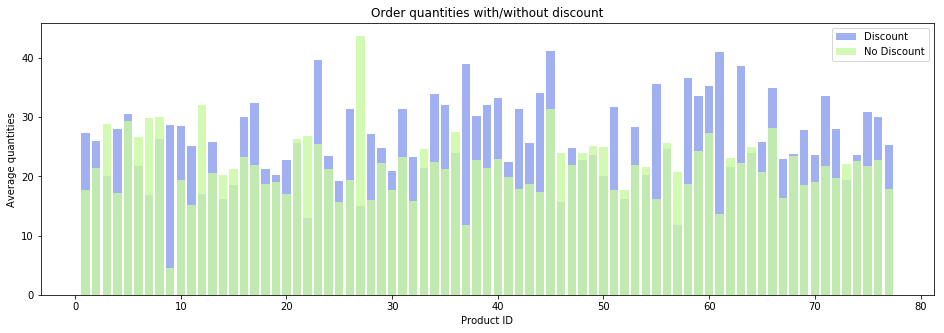

Conclusion
On average 70.0% of discounted products were sold in larger quantities
Average order quantity with discount - 26.43 items, without - 21.81 items


In [28]:
discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(16,5))
plt.bar(discount.index, discount.values, alpha=1, label='Discount', color='#a0b0f0')
plt.bar(no_discount.index, no_discount.values, alpha=0.8, label='No Discount', color='#c9f9a0')
plt.legend()
plt.title('Order quantities with/without discount')
plt.xlabel('Product ID')
plt.ylabel('Average quantities')
plt.show()

print('Conclusion')
print("On average {}% of discounted products were sold in larger quantities".format(round(sum(discount.values > no_discount.values)/len(discount.values)*100),2))
print("Average order quantity with discount - {} items, without - {} items".format(round(discount.values.mean(),2), round(no_discount.values.mean(),2)))

## Orders grouped by discount level

In [12]:
# Let's get all discount levels
discounts = OrderDetail_df['Discount'].unique()
discounts.sort()
print('Discount levels')
print(discounts)

Discount levels
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.1  0.15 0.2  0.25]


In [13]:
# Group orders by discount amounts
# Each group is a DataFrame containing orders with certain discount level
groups = {}
for i in discounts:
    groups[i] = OrderDetail_df[OrderDetail_df['Discount']==i]

In [14]:
discounts_df = pd.DataFrame(columns=['Discount %','Orders','Avg. Order Quantity'])
for i in groups.keys():
    discounts_df = discounts_df.append({'Discount %':i*100,'Orders':len(groups[i]),'Avg. Order Quantity':groups[i]['Quantity'].mean()}, ignore_index=True)

discounts_df

,Discount %,Orders,Avg. Order Quantity
0,0.0,1317.0,21.715262
1,1.0,1.0,2.000000
2,2.0,2.0,2.000000
3,3.0,3.0,1.666667
4,4.0,1.0,1.000000
5,5.0,185.0,28.010811
6,6.0,1.0,2.000000
7,10.0,173.0,25.236994
8,15.0,157.0,28.382166
9,20.0,161.0,27.024845


Table above shows that 1%, 2%, 3%, 4% and 6% discounts are small and to draw concultion based on this might be problematic as this might look like there will be neagive impact on the orders one of the reason might be that there was a promotion going on for new product or new customers and they just placed order to redeem that promotion. So ideal we would like to drop that level for experiment.

## Resampling

Bootstrapping is a type of resampling where large numbers of smaller samples of the same size are repeatedly drawn, with replacement, from a single original sample.

In [15]:
def bootstrap(sample, n):
    bootstrap_sampling_dist = []
    for i in range(n):
        bootstrap_sampling_dist.append(np.random.choice(sample, size=len(sample), replace=True).mean())
    return np.array(bootstrap_sampling_dist)

## Cohen's d

Cohen's d is an effect size used to indicate the standardised difference between two means. It can be used, for example, to accompany reporting of t-test and ANOVA results. It is also widely used in meta-analysis. Cohen's d is an appropriate effect size for the comparison between two means.

In [16]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

## Visualization

In [17]:
def visualization(control, experimental):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=50,  label='Experimental')
    sns.distplot(control, bins=50,  label='Control')

    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')

    plt.title('Control and Experimental Sampling Distributions', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

## Question #1

### Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

- $Null Hypothesis$ : there is no difference in order quantity due to discount
- $Alternative Hypothesis$ : there is an increase in order quantity due to discount


Usually discount increases order quantity, so it would be reasonable to perform one-tailed test with $\alpha$ set to 0.025. If $p$ < $\alpha$, we reject null hypothesis.

# Welch's T-test

Reject Null Hypothesis
Cohen's d: 0.2862724481729282


C:\Users\mitjp\AppData\Local\conda\conda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


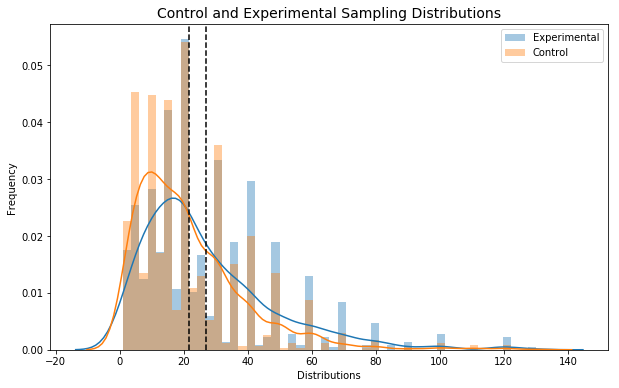

In [18]:
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
experimental = OrderDetail_df[OrderDetail_df['Discount']!=0]['Quantity']

t_stat, p = stats.ttest_ind(control, experimental)
d = Cohen_d(experimental, control)

print('Reject Null Hypothesis') if p < 0.025 else print('Failed to reject Null Hypothesis')
print("Cohen's d:", d)
visualization(control, experimental)

Result of the experiment shows that there is a statistically significant difference in orders quantities, hence we reject null hypothesis

The following step in the research would be to answer the question about at what discount level we see statisticaly significant difference in orders quantities

In [19]:
discounts_significance_df = pd.DataFrame(columns=['Discount %','Null Hypothesis','Cohens d'], index=None)

discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
for i in discounts:
    experimental = OrderDetail_df[OrderDetail_df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(control, experimental)
    d = Cohen_d(experimental, control)
    discounts_significance_df = discounts_significance_df.append( { 'Discount %' : str(i*100)+'%' , 'Null Hypothesis' : 'Reject' if p < 0.025 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discounts_significance_df

,Discount %,Null Hypothesis,Cohens d
0,5.0%,Reject,0.346877
1,10.0%,Reject,0.195942
2,15.0%,Reject,0.372404
3,20.0%,Reject,0.300712
4,25.0%,Reject,0.366593


Result of the test shows that there is statistically significant difference in quantities between orders with no discount and applied discounts of 5%, 10%, 15%, 20%, 25%. Hence we reject null hypothesis

## Statistically significant difference between discount levels

- $Null Hypothesis$ : there is no difference in order quantity between discounts
- $Alternative Hypothesis$ : there is a difference in order quantity between discounts

In [21]:
discounts = np.array([0.05, 0.1, 0.15, 0.2, 0.25])
comb = itertools.combinations(discounts, 2)
discount_levels_df = pd.DataFrame(columns=['Discount %','Null Hypothesis','Cohens d'], index=None)

for i in comb:
    
    control =      OrderDetail_df[OrderDetail_df['Discount']==i[0]]['Quantity']
    experimental = OrderDetail_df[OrderDetail_df['Discount']==i[1]]['Quantity']
    
    st, p = stats.ttest_ind(experimental, control)
    d = Cohen_d(experimental, control)
    
    discount_levels_df = discount_levels_df.append( { 'Discount %' : str(i[0]*100)+'% - '+str(i[1]*100)+'%', 'Null Hypothesis' : 'Reject' if p < 0.05 else 'Failed', 'Cohens d' : d } , ignore_index=True)    

discount_levels_df.sort_values('Cohens d', ascending=False)

,Discount %,Null Hypothesis,Cohens d
4,10.0% - 15.0%,Failed,0.149332
6,10.0% - 25.0%,Failed,0.145146
0,5.0% - 10.0%,Failed,0.127769
5,10.0% - 20.0%,Failed,0.089008
7,15.0% - 20.0%,Failed,0.068234
9,20.0% - 25.0%,Failed,0.062415
2,5.0% - 20.0%,Failed,0.047644
1,5.0% - 15.0%,Failed,0.017179
3,5.0% - 25.0%,Failed,0.010786
8,15.0% - 25.0%,Failed,0.006912


### Result 

Result of the test shows that there is no statistically significant difference in order quantity between discounts of 5%, 10%, 15%, 20% and 25%.


## Question 2

## Is there a statistically significant difference in performance of shipping companies?

- $Null Hypothesis$ : There is no difference in performance of shipping companies
- $Alternative Hypothesis$ : There is difference in performance of shipping companies

In [22]:

Order_df.OrderDate = pd.to_datetime(Order_df.OrderDate)
Order_df.ShippedDate = pd.to_datetime(Order_df.ShippedDate)
Order_df.RequiredDate = pd.to_datetime(Order_df.RequiredDate)

Order_df['ProcessingTime'] = Order_df.ShippedDate - Order_df.OrderDate
Order_df['ShippingTime'] = Order_df.RequiredDate - Order_df.ShippedDate

Order_df.ShippingTime = Order_df.ShippingTime.dt.days
Order_df.ProcessingTime = Order_df.ProcessingTime.dt.days

In [23]:
Order_df.groupby('ShipVia').mean()

,Id,EmployeeId,Freight,ProcessingTime,ShippingTime
ShipVia,,,,,
1,10667.594378,4.232932,65.001325,8.571429,19.485714
2,10674.963190,4.536810,86.640644,9.234921,18.765079
3,10641.592157,4.400000,80.441216,7.473896,19.963855


In [24]:
formula = 'ProcessingTime ~ C(ShipVia)'
lm = ols(formula, Order_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq     df         F    PR(>F)
C(ShipVia)    433.501581    2.0  4.676819  0.009563
Residual    37354.696194  806.0       NaN       NaN


In [27]:
Shipper_df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


### Result
Result of the test shows that there is a statistically significant difference in performance of shipping companies, hence we reject null hypothesis

## Question 3

### Is there a statistically significant difference in discount between categories?

- $Null Hypothesis$  : There is no difference in discount level between categories
- $Alternative Hypothesis$  : There is a difference in discount level between categories

In [25]:
category_discount = pd.read_sql_query('''

                        SELECT OrderDetail.UnitPrice, Discount, CategoryId FROM OrderDetail
                        JOIN Product
                        ON OrderDetail.ProductId = Product.Id

''',conn)

In [26]:
formula = 'Discount ~ C(CategoryId)'
lm = ols(formula, category_discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                  sum_sq      df         F    PR(>F)
C(CategoryId)   0.074918     7.0  1.539545  0.149326
Residual       14.925422  2147.0       NaN       NaN


### Result 
Result of the test shows that there is no statistically significant difference in discount level between categories, hence we failed to reject null hypothesis

## Question 4

### Does the average revenue per order vary between customers from different regions?

- $ Null Hypothesis$ : the average amount spent per order is the same between different customer regions
- $Alternative Hypothesis$ : the average amount spent per order is different (either higher or lower) between different customer regions

Query to select the required data from the database

In [32]:
region_details = pd.read_sql_query('''
 SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
 FROM Customer c
 JOIN [Order] o ON c.Id = o.CustomerId
 JOIN OrderDetail od ON od.OrderId = o.Id
 ''', conn)

In [33]:
region_details.head()

,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,12,14.0,0.0
1,Western Europe,10248,10,9.8,0.0
2,Western Europe,10248,5,34.8,0.0
3,Western Europe,10249,9,18.6,0.0
4,Western Europe,10249,40,42.4,0.0


In [34]:
# Calculating the revenue per sub-order
region_details['price_per_order'] = region_details.Quantity * region_details.UnitPrice *(1- region_details.Discount)

# Dropping the columns for quantity, unit price and discount now that we have the total revenue
region_details.drop(['Quantity','UnitPrice','Discount'], axis=1, inplace= True)

# Grouping the data by order and summing the revenue for each order
region_details = region_details.groupby(['Region','OrderId'])['price_per_order'].sum().reset_index()

# Dropping the OrderId as we no longer need this
region_details.drop('OrderId', axis=1, inplace=True)

In [35]:
region_details.head()

,Region,price_per_order
0,British Isles,479.4
1,British Isles,2645.0
2,British Isles,1762.0
3,British Isles,516.8
4,British Isles,240.4


In [36]:
region_details.groupby('Region').count()

,price_per_order
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


Let's Combine the geographical location to make more sense.

In [40]:
# Combining Eastern and Southern Europe
region_details.loc[(region_details.Region == 'Eastern Europe') | (region_details.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'

# Combining Scandinavia and Northern Europe
region_details.loc[(region_details.Region == 'Scandinavia') | (region_details.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'

# Combining Central and South America
region_details.loc[(region_details.Region == 'Central America') | (region_details.Region == 'South America'),'Region'] = 'South and Central America'

In [41]:
region_details.groupby('Region').count()

,price_per_order
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central America,148
Southern and Eastern Europe,71
Western Europe,272


## Visualization of the data 

Now that the data is in right formate and grouped correctly let's explore the data.

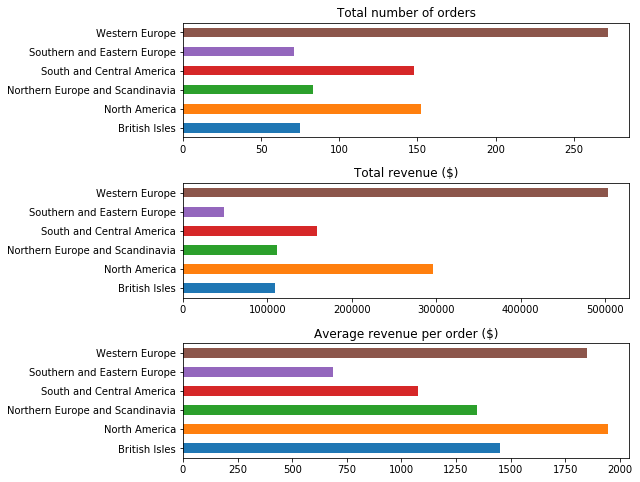

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
region_details.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
region_details.groupby(['Region'])['price_per_order'].sum().plot(kind='barh', ax=ax2)
region_details.groupby(['Region'])['price_per_order'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total revenue ($)')
ax2.set_ylabel('')
ax3.set_title('Average revenue per order ($)')
ax3.set_ylabel('')
fig.subplots_adjust(hspace=0.4);

In [39]:
formula = 'price_per_order ~ C(Region)'
lm = ols(formula, region_details).fit()
sm.stats.anova_lm(lm,typ=2)

,sum_sq,df,F,PR(>F)
C(Region),1.386334e+08,5.0,8.469639,8.023836e-08
Residual,2.602556e+09,795.0,NaN,NaN


## Result 

The ANOVA table above revealed that the p-value is lower than the alpha value. Therefore, we are able to reject the null hypothesis and we can say that there are statistically significant difference in average order value between different regions.